In [1]:
# !pip install missingno
# !pip install --user catboost -U
# !pip install --user imblearn
# !pip install --user -U seaborn
# !pip install --user -U matplotlib

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Изучить данные    
    1.1. Вычислите эффективность обогащения на обучающей выборке для признака `rougher.output.recovery`    
    1.2. Найти MAE между расчётами и значением признака.
2. Провести исследовательский анализ данных  
    2.1. Показать как меняется концентрация металлов на различных этапах очистки.  
    2.2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках.  
    2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях
3. Построить и обучить модель.  
    3.1. Написать функцию для вычисления итоговой sMAPE.  
    3.2. Обучить разные модели и оцените их качество кросс-валидацией.  

## Знакомство с данными

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import scipy.stats as stats

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

from sklearn.multioutput import MultiOutputRegressor

from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

import tensorflow.keras as k

In [3]:
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', parse_dates=['date'])
df = pd.read_csv('/datasets/gold_recovery_train_new.csv', parse_dates=['date'])
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', parse_dates=['date'])

В нашем распоряжении 3 файла.  
`gold_recovery_full_new.csv` - содержащий полную выборку данных  
Которая заранее разбита на тренировочную в файле `gold_recovery_train_new.csv`  
и тестовую в `gold_recovery_test_new.csv`

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19438 non-null  float64       
 2   final.output.concentrate_pb                         19438 non-null  float64       
 3   final.output.concentrate_sol                        19228 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19438 non-null  float64       
 7   final.output.tail_pb                                19338 non-null  float64       
 8   final.

Названия признаков сложносоставные и описывают показатели различных стадий  

-----------------------------------------------------------------------------------------------------------------------------
`rougher` - первичная   

Последующая состоящая из 
первичной `primary_cleaner` 
и вторичной очистки`secondary_cleaner` 

Заключающая `final`

---------------------------------------------------
`input` показатели перед стадией  
`output` после прохождения стадии  
`calculation` вычисляемые  

---------------------------------------------------
`state.floatbank...` - технологические показатели узла

---------------------------------------------------
`concentrate_...` - концентрация веществ в растворе переходящий на дальнейшую стадию  
`tail_...` - концентрация веществ в растворе удаляемом из основного цикла  


<AxesSubplot:>

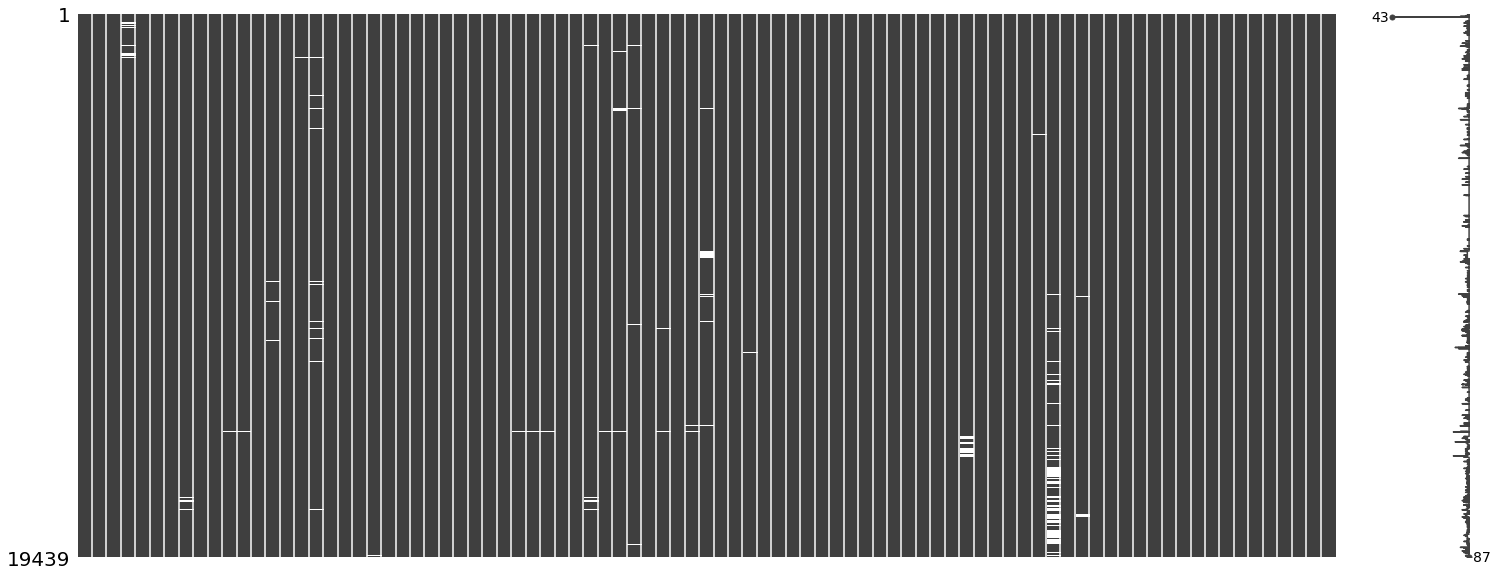

In [5]:
msno.matrix(df_full)

в данных имеется значительное количество пропусков

<AxesSubplot:>

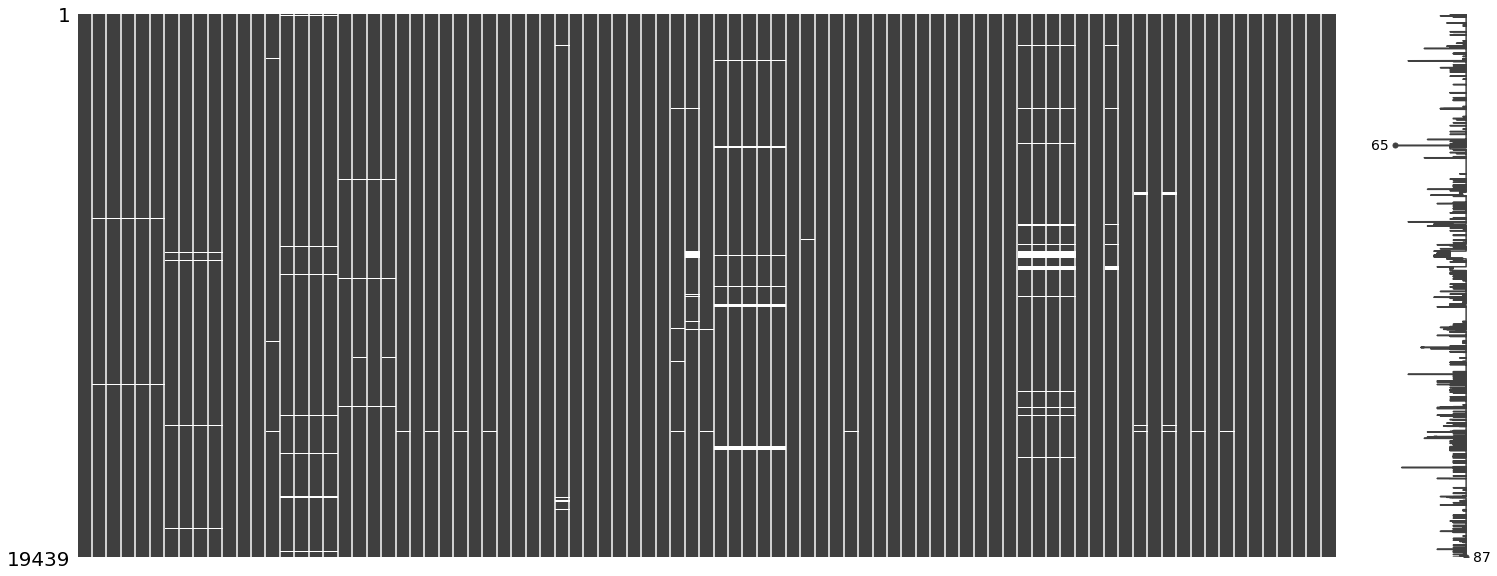

In [6]:
msno.matrix(df_full.fillna(1)[df_full.fillna(1).round(1)!=0])

и нулевых значений

In [7]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Зачастую в тех местах где это не разумно с технологической точки зрения. И связано скорей всего со сбоем измерительного оборудования.

Не буду душить аналогичными простынями текста с двух других файлов. Сыграем на доверии.  
Описанное выше справедливо также и для файлов с тренировочной и тестовой выборками

## Анализ данных

Согласно условию, данные в признаке `rougher.output.recovery` рассчитываются по формуле

$$ Recovery = \frac{C*(F-T)}{F*(C-T)} *100\% $$

где    
C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.  

Что мы и проверим

In [8]:
def rou_calc(concentrate, feed_au, tail_au):
  return (concentrate*(feed_au-tail_au))/(feed_au*(concentrate-tail_au))*100

In [9]:
df_routher = pd.DataFrame()
df_routher['available_rou'] = df['rougher.output.recovery']
df_routher['calculated_rou'] = rou_calc(df['rougher.output.concentrate_au'],
                                        df['rougher.input.feed_au'],
                                        df['rougher.output.tail_au'])
df_routher = df_routher.round(6)

In [10]:
print(f''' MAE: {
mean_absolute_error(df_routher['available_rou'].dropna(), df_routher['calculated_rou'].dropna())} ''')

 MAE: 0.0 


Взглянем на изменениие концентрации веществ в зависимости от этапа обработки

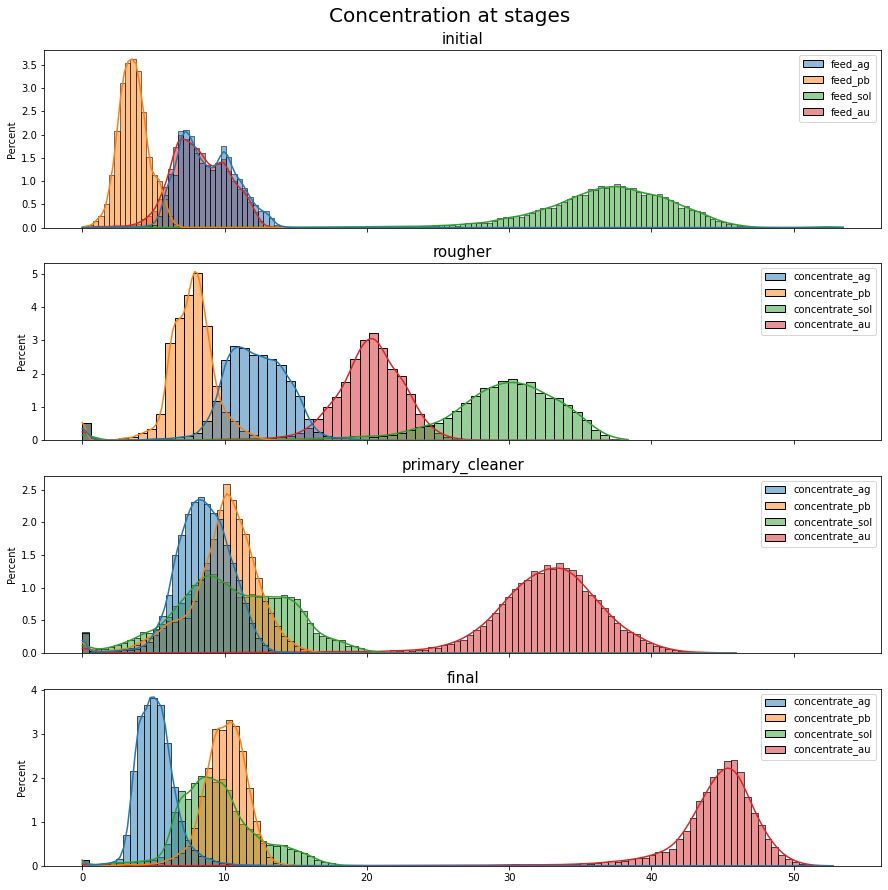

In [11]:
stages = ['rougher', 'primary_cleaner','final']
f, axs = plt.subplots(4,1, figsize=(15,15), sharex=True)
plt.suptitle('Сoncentration at stages', fontsize=20, y=0.92)

sns.histplot(ax=axs[0],
               data=df_full\
                  .filter(regex='rougher\.input\.feed_[agpbusol]{2,3}',axis=1)\
                  .rename(columns=lambda x: x.split('.')[-1]),
               stat='percent', kde=True).set_title('initial', fontsize=15)

for i, stage in enumerate(stages):
  sns.histplot(ax=axs[i+1],
               data=df_full\
                  .filter(like=f'{stage}.output.concentrate', axis=1)\
                  .rename(columns=lambda x: x.split('.')[-1]),
               stat='percent', kde=True).set_title(stage, fontsize=15)

Так как компания золотодобывающая, весьма логично видеть на графиках, что технология позволяет увеличивать концентрацию золота в дисперсии.

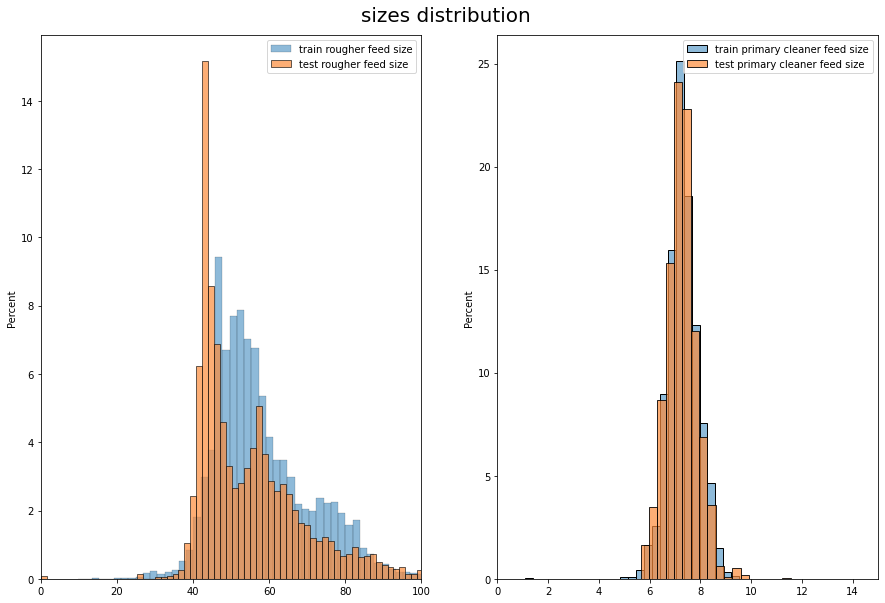

In [12]:
f, axs = plt.subplots(1,2, figsize=(15,10))
plt.suptitle('sizes distribution', fontsize=20, y=0.92)

sns.histplot(ax=axs[0],
             data=df.filter(like='rougher.input.feed_size', axis=1),
             bins=250, stat='percent').set_xlim(0,100)

sns.histplot(ax=axs[0],
             data=df_test.filter(like='rougher.input.feed_size', axis=1),
             bins=250, stat='percent', palette='Oranges', alpha=0.7).set_xlim(0,100)

axs[0].legend(['train rougher feed size', 'test rougher feed size'])

sns.histplot(ax=axs[1],
             data=df.filter(like='cleaner.input.feed_size', axis=1),
             bins=30, stat='percent').set_xlim(0,15)
sns.histplot(ax=axs[1],
             data=df_test.filter(like='cleaner.input.feed_size', axis=1),
             bins=30, stat='percent', palette='Oranges', alpha=0.7).set_xlim(0,15)

axs[1].legend(['train primary cleaner feed size', 'test primary cleaner feed size'])


Если распределение гранул в обучающей и тестовой выборке на этапе вторичной очистки несомненно идентичны, то вот изначальный их размер в выборках весьма не похож

In [13]:
print(f'''p-value: {
stats.ttest_ind(df['rougher.input.feed_size'].dropna(), df_test['rougher.input.feed_size'].dropna()).pvalue}''')

p-value: 7.865316540588674e-33


Что подтвержается статистически. Но изначальные условия не предоставляют выбора, поэтому продолжаем работать с тем, что имеется

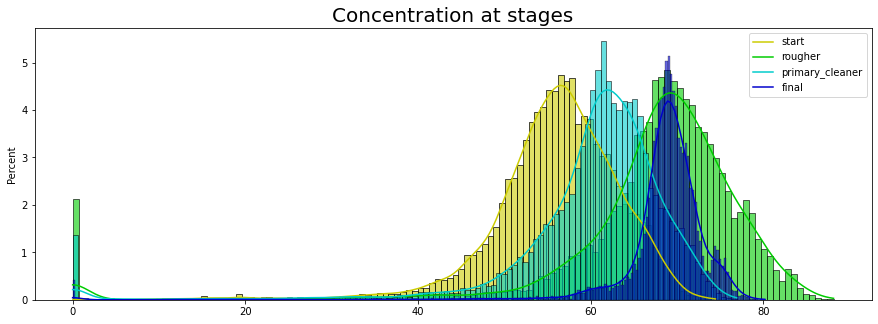

In [14]:
stages = ['rougher', 'primary_cleaner', 'final']
colors = ['#00CC00', '#00CCCC','#0000CC']

plt.figure(figsize=(15,5))
plt.title('Сoncentration at stages', fontsize=20)

sns.histplot(data=df.filter(regex='rougher\.input\.feed_[agpbusol]{2,3}',
                            axis=1).sum(axis=1),
              stat='percent',
              kde=True,
              color='#CCCC00',
              alpha=0.6)

for color, stage in zip(colors,stages):
  sns.histplot(data=df.filter(like=f'{stage}.output.concentrate_',
                              axis=1).sum(axis=1),
                stat='percent',
                kde=True,
                color=color,
                alpha=0.6)
# c цветами получилось как-то не очень изящно и не очень красиво. Может есть способ получше?
plt.legend(['start', 'rougher', 'primary_cleaner', 'final'])

А это суммарная концентрация веществ на разных этапах. Учитывая сложность технологии, не имею компетенции и информации, чтобы делать из этого какие-либо выводы

## Подготовка данных

Как мы неоднократно убедились ранее в данных много пропусков, выбросов и нулевых значений как в тренировочной так и в тестовой выборке. Для дальнейшей работы почистим данные от них.

In [15]:
df = df.drop('date', axis=1) 
df = df[df.round(1)!=0] # удаляем нулевые и минимально отклонившиеся от нуля данные
df_clean = df[((df<df.quantile(0.99)) & (df>df.quantile(0.01))).all(axis=1)] # удаляем выбросы

In [16]:
df_test_clean = df_test.merge(df_full[['date',
                                 'rougher.output.recovery',
                                 'final.output.recovery']],
                            how='left',
                            on='date') # добавляем целевые признаки
df_test_clean = df_test_clean[df_test_clean.round(1)!=0] # чистим от нулей в то числе и в целевых признаках
df_test_clean = df_test_clean.dropna() 

## Модель

Эффективность модели будет оцениваться по сумме симметричных средних абсолютных процентных отклонений (sMAPE) для двух признаков по формуле

$$ 25\% \ sMAPE(routher) + 75\% \  sMAPE(final) $$

где

$$ sMAPE = \frac{1}{N} \sum \frac{|y-\overline{y}|}{(|y|+|\overline{y}|)/2}*100\% $$

где  
$y$ - значение целевого признака для объекта  
$\overline{y}$ - значение предсказания для объекта  
$N$ - количество объектов в выборке  

In [17]:
def smape(y_true, y_pred):
    return ((np.abs(y_true-y_pred))/((np.abs(y_true)+np.abs(y_pred))/2)).mean()*100

def smape_sum(y_true, y_pred): # ['rougher.output.recovery','final.output.recovery']
  
  rou_rec_pred = y_pred.T[0]  
  rou_rec_true = y_true['rougher.output.recovery'].values
  
  final_rec_pred = y_pred.T[1]
  final_rec_true = y_true['final.output.recovery'].values
    
  return 0.25*smape(rou_rec_true, rou_rec_pred)+0.75*smape(final_rec_true, final_rec_pred) 

scorer = make_scorer(smape_sum, greater_is_better=False) #для дальнейшего cross_val_score

Разделяй и ~властвуй~ тренируй

In [18]:
df_train_X = df_clean.loc[:, df_test.drop(['date'], axis=1).columns]
df_train_y = df_clean[['rougher.output.recovery',
                        'final.output.recovery']]

df_test_X = df_test_clean.drop(['date',
                          'rougher.output.recovery',
                          'final.output.recovery'],
                          axis=1)
df_test_y = df_test_clean[['rougher.output.recovery',
                           'final.output.recovery']]


обучим и оценим качество используемых моделей как и просили на `cross_val_score`

сумма sMAPE для средней константы

In [19]:
x = df_clean[['rougher.output.recovery','final.output.recovery']]

primary_smape = (((x-x.mean()).abs())/((x+x.mean())/2)).mean()*100

0.25*primary_smape[0]+0.75*primary_smape[1]

7.292748129407008

сумма sMAPE для DummyRegressor

In [20]:
dum = DummyRegressor(strategy='mean')
np.absolute(cross_val_score(dum, df_train_X, df_train_y, cv=5, scoring=scorer).mean())
# здесь тоже не понял почему возникает разница на 0.5

7.841708713642781

сумма sMAPE для SVR

In [21]:
multi_liner = MultiOutputRegressor(SVR(C=2.5, epsilon=0.2))
pipe_liner = make_pipeline(StandardScaler(), multi_liner)

np.absolute(cross_val_score(pipe_liner, df_train_X, df_train_y, cv=5, scoring=scorer).mean())

6.630306958168182

сумма sMAPE для KNN

In [22]:
multiKNR = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=150))
pipe_multiKNR = make_pipeline(StandardScaler(), multiKNR)

np.absolute(cross_val_score(pipe_multiKNR, df_train_X, df_train_y, cv=5, scoring=scorer).mean())

7.376890887114458

сумма sMAPE для catboost

In [23]:
cbr = CatBoostRegressor(iterations=2000,
                        loss_function='MultiRMSE',
                        depth=7,
                        early_stopping_rounds=300,
                        learning_rate=0.1,
                        verbose=0)

np.absolute(cross_val_score(cbr, df_train_X, df_train_y, cv=5, scoring=scorer).mean())

6.66669729143802

бонус

In [24]:
scaler = StandardScaler()
scaler.fit_transform(df_train_X)
df_train_X = scaler.transform(df_train_X)

In [25]:
ker_model = k.Sequential()
ker_model.add(k.layers.Dense(units=100, input_dim=52, activation='relu'))
ker_model.add(k.layers.Dropout(0.5))
ker_model.add(k.layers.Dense(units=50, input_dim=100, activation='tanh'))
ker_model.add(k.layers.Dropout(0.5))
ker_model.add(k.layers.Dense(units=2, input_dim=50, activation='relu'))
ker_model.compile(loss='mse', optimizer='adam')

2022-03-18 11:37:10.186771: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Оценим качество моделей на тестовой выборке

In [26]:
models = [dum, pipe_liner, pipe_multiKNR, cbr, ker_model]
scores = {}

for model in models:
  if model.__class__.__name__ == 'Sequential':
      model.fit(x=df_train_X, y=df_train_y, epochs=500, validation_split=0.1, batch_size=5, verbose=0)
      scores[f'{model.__class__.__name__}'] = smape_sum(df_test_y, model.predict(scaler.transform(df_test_X)))
      continue
        
  model.fit(df_train_X, df_train_y)

  if model.__class__.__name__ == 'Pipeline':
      scores[f'{model[-1].estimator.__class__.__name__}'] = smape_sum(df_test_y, model.predict(df_test_X))

  else: scores[f'{model.__class__.__name__}'] = smape_sum(df_test_y, model.predict(df_test_X))


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/jovyan/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


И визуализируем результат

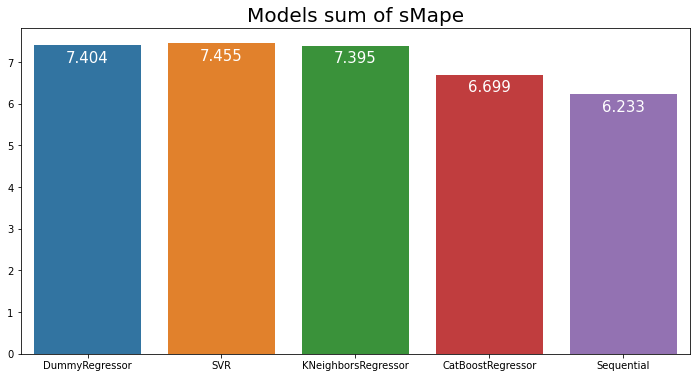

In [27]:
plt.figure(figsize=(12,6))
plt.title('Models sum of sMape', fontsize=20)
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.bar_label(ax.containers[0], padding=-20, fontsize=15, fmt='%.3f', c='white');

## Выводы

Модели позволяют получить небольшое преимущество относительно константного среднего значения. Но требуется усилить способы получения актуальных данных.